Vesttoo ARIMA Home Test - Itay Vegh - 2022
***

# Task 1

## 
> Create a PyTorch module describing an ARIMA(0,1,1) time series.

In [1]:
import torch
import seaborn as sns
import pandas as pd
import numpy as np
import math

In [2]:
class ARIMA011(torch.nn.Module):
    
    """
    This Class describes a PyTorch Module of an ARIMA(0,1,1)
    time-seris process, a simple exponential average with a drift.
    Such a model has two parameters: the drift velocity (drift)
    and the amount of exponential decay (alpha). 
    """
    
    def __init__(self,ma_L1=0.5,x1=0.5):
        super(ARIMA011, self).__init__()
        
        self.ma_L1 = torch.nn.Parameter((torch.ones(1)*ma_L1))
        self.x1 = torch.nn.Parameter((torch.ones(1)*x1))
    
    def forward(self, errors):
        """
        * Given additional time it is probably possible to improve the time complexity 
        of this function, using tensor computations instead of the main "for" loop.
        We assume that the errors are normally distributed with mean 0 and sigma 1.
        """
        
        n = len(errors)
        observed = torch.zeros(n)
        forecast = torch.zeros(n)
        
        for i in range(0,n):
            # print(observed)
            if i==0:
                forecast[i]=0
            else:
                forecast[i]=forecast[i-1]+(1+self.ma_L1)*errors[i-1]+self.x1
            observed[i] = (forecast[i]+errors[i])

        # observed=observed.clone()-observed[1]
        # observed[0] = 0
        
        return observed
    
    def fit(self,y,iters=5000,verbose=0):
        """
        Calculating the maximum likelihood parameters of an ARIMA(0,1,1) model.
        The values of alpha and drift which gives the highest likelihood for the observed values. 
        """
        optim = torch.optim.SGD(model.parameters(), lr=0.0001, momentum=0.25)


        self.x1.data = (y-y.roll(1))[1:].mean()
        # self.ma_L1 = torch.nn.Parameter(torch.ones(1))  
        
        for values in range(iters):
            loss = -self.log_likelihood_arima(y.clone(),verbose=verbose)
            optim.zero_grad()
            loss.backward(retain_graph=True)
            optim.step()


        return
    
    
    # def likelihood_normal(self,x,mu,sigma):
#         denomerator = sigma*((2*math.pi)**(0.5))

#         numerator = torch.exp(-(((x-mu)**2)/(2*sigma)))
#         return numerator/denomerator



    def log_likelihood_arima(self,y,verbose=0):

        # eps = 1e-10
        ll = 0
        prev_error = None
        
        ma_L1,x1 = self.parameters()
        if verbose>0:
            print("x1",x1,"ma_L1",ma_L1,"ll",ll)
            
        for i in range(len(y)):
            if i==0:
                error=torch.zeros(1)
            else:
                error = (y[i]-y[i-1])-(ma_L1*prev_error)-x1 
            prev_error = error
            ll+=(error**2)
            # print(ll)
            # ll+=torch.log(self.likelihood_normal(x=error,mu=0,sigma=1)+eps)
        
        if verbose>0:
            print("x1",x1,"ma_L1",ma_L1,"ll",ll)
        
        return -ll

In [3]:
# sanity check for simulation generator using statsmodels ARIMA

import numpy as np
from statsmodels.tsa.api import ARIMA

def simulate_ARIMA011_test(N,x1,ma_L1,plot=False,verbose=0):
    if verbose>0:
        print("simulating ARIMA(0,1,1) model")

    sigma = 1

    zero_dta = np.zeros(N)

    modl = ARIMA(zero_dta, order = (0,1,1),trend="t",trend_offset=0)
    np.random.seed(100)
    errors = ARIMA(zero_dta, order = (0,0,0)).simulate(params=[0,1],nsimulations=N)
    params = (x1,ma_L1,sigma,)
    if verbose>0:
        print("(ma_L1,sigma)",params)
    np.random.seed(100)
    sims = modl.simulate(params=params,nsimulations=N,trend_offset=0)
    sims[0] = None
    sims-=sims[1]
    if plot:
        sns.lineplot(data=sims,label="arima")
        sns.lineplot(data=errors,label="errors")
    return sims,errors

def fit_ARIMA011_test(y):
    np.random.seed(100)
    sigma=1
    modl = ARIMA(y, order = (0,1,1),trend="t",trend_offset=0)
    res = modl.fit_constrained({"sigma2":sigma})
    return res.params




TEST PyTorch generative Module

passed sanity check for x1=0 , ma_L1=0
passed sanity check for x1=0 , ma_L1=1
passed sanity check for x1=10 , ma_L1=0
passed sanity check for x1=1 , ma_L1=10
passed sanity check for x1=0.33 , ma_L1=0.55
passed sanity check for x1=-1 , ma_L1=-0.3
passed sanity check for x1=1 , ma_L1=-0.3


/opt/homebrew/Caskroom/miniforge/base/envs/base_env_39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/homebrew/Caskroom/miniforge/base/envs/base_env_39/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


<AxesSubplot:>

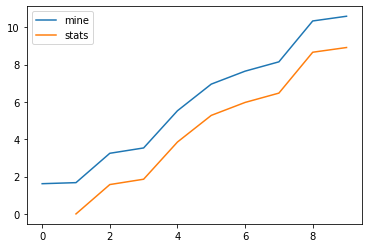

In [4]:
# simulate some tests

params = [(0,0),(0,1),(10,0),(1,10),(0.33,0.55),(-1,-0.3),(1,-0.3)]
for p in params:
    x1 = p[0]
    ma_L1 = p[1]
    y_sm,errors_sm = simulate_ARIMA011_test(N=10,x1=x1,ma_L1=ma_L1,plot=False)
    fit_ARIMA011_test(y_sm)
    y_sm,errors_sm,y_sm-errors_sm
    
    my_y = ARIMA011(x1=x1,ma_L1=ma_L1).forward(errors_sm).detach().numpy()    
    assert (my_y-y_sm)[1:].std()<0.01
    print(f"passed sanity check for x1={p[0]} , ma_L1={p[1]}")
    

sns.lineplot(data=my_y,label="mine")
sns.lineplot(data=y_sm,label="stats")

## 
> Generate a random 20 sample long ARIMA(0,1,1) time series with drift.

(tensor([ 1.9269,  1.4873,  0.9007, -2.1055, -0.7581,  1.0783,  0.8008,  1.6806,
          0.3559, -0.6866, -0.4934,  0.2415, -0.2316,  0.0418, -0.2516,  0.8599,
         -0.3097, -0.3957,  0.8034, -0.6216]),
 tensor([  1.9269,   9.3777,  16.0220,  19.3669,  22.5560,  28.2552,  34.5952,
          41.6762,  47.8724,  52.3637,  56.5270,  61.5218,  66.4109,  71.3369,
          76.1062,  81.8402,  86.9604,  91.4099,  97.0154, 101.7955],
        grad_fn=<CopySlices>))

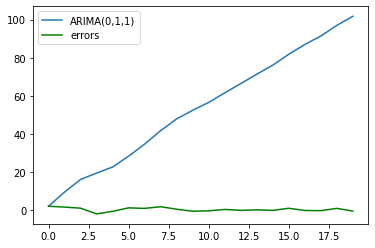

In [5]:
A011 = ARIMA011(x1=5,ma_L1=0.5)
torch.manual_seed(42)

N = 20

v = torch.normal(0,1,size=tuple([N])) # IID NOISE
# v[0] = 1

y=A011(v)
sns.lineplot(data=y.detach().numpy(),label="ARIMA(0,1,1)")
sns.lineplot(data=v.detach().numpy(),color="green",label="errors")
v,y

We define the model fit process as finding the maximum likelihood
parameters that fit the training data set.

## 
> Fit the model parameters to a training data set comprised of the first 14 samples of the time series generated in the second item.

<AxesSubplot:>

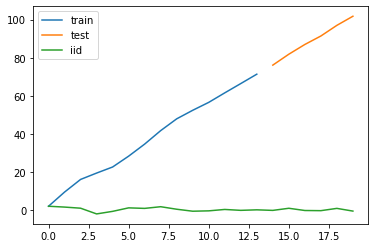

In [6]:
train = y[:14]
test = y[14:]
train,test


sns.lineplot(data=torch.cat((train,test*np.nan)).detach().numpy(),label="train")
sns.lineplot(data=torch.cat((train*np.nan,test)).detach().numpy(),label="test")
sns.lineplot(data=v,label="iid")

In [7]:
model =  ARIMA011(x1=0,ma_L1=0)
model.fit(train,verbose=0,iters=5000)

## 
> Calculate the probability of observing a testing data set comprised of last 6 samples given the model fitted in the previous step

In [8]:
model.log_likelihood_arima(test)

tensor([-2.6543], grad_fn=<NegBackward0>)

# Task 2

## 
> Describe how you would do the task in 1.2.1 given a training data set comprised of first and last 7 samples and a testing data set comprised of the remaining samples.

Given a dataset of 7 first and last samples, we don't have as many differences from which we can calculate the errors.
We can look at the problem as one with two time-series and a non-contiguous break in between them.
If our data is composed of T = t1,t2,t3
So then:
   > loss(T,x1,ma_L1) = loss(t1,x1,ma_L1)+loss(t3,x1,ma_L1)
    
And we can use a similar optimization technique to find the optimal values.
* When working with time series we may get optimistic validation results due to look-ahead-bias (training on t3 and validating on t2).